# Merge the candidates from the different candidate sources #

In [ ]:
local = False
if local:
  from google.colab import drive
  drive.mount('/content/drive')
  %cd /content/drive/MyDrive/'Kaggle Otto Reccommender'/data
  path_to_module = '/content/drive/MyDrive/Kaggle Otto Reccommender/'
else:
  !mkdir /my_mnt_dir
  !google-drive-ocamlfuse /my_mnt_dir
  %cd /my_mnt_dir/'Kaggle Otto Reccommender'/data
  path_to_module = '/my_mnt_dir/Kaggle Otto Reccommender/'

import sys    
sys.path.append(path_to_module)

In [ ]:
!pip install fastparquet

In [ ]:
import glob
import numpy as np
import pandas as pd
import gc
import os
from otto_utils import save_parquet, create_sub, convert_columns, make_directory
from tqdm import tqdm
import seaborn as sns

In [ ]:
validation=True
verbose=False
candidate_limit = 200 # Max number of candidates

n_basket = 200 # Take up to 200 basket candidates

also_buy = True
n_also_buy = 150

covisitation = True
n_covisitation = 200 # Take up to 200 covisitation candidates

cart_order = True
n_cart_order = 150

word2vec = True
n_word2vec = 100 # Take up to 100 word2vec candidates

als = True
n_als = 200 # Take up to 200 ALS candididates

path_to_candidate_features = './train_candidate_features' if validation else './test_candidate_features'
path_to_training_data = './train_training_data' if validation else './test_training_data'

if verbose and validation:
  labels = pd.read_parquet('./validation/test_labels.parquet')
else:
  verbose = False

In [ ]:
labels = pd.read_parquet('./validation/test_labels.parquet')

In [ ]:
def combine_candidate_dfs(df1, df2, candidate_limit, source):
  '''df1 is the existing table, and df2 must contain a column n prioritising the aids by session '''

  df1['existing'] = True
  df2['existing'] = False
  rank_name = 'n_' + source
  df2.rename(columns={'n' : rank_name}, inplace=True)
  combined_df = pd.concat([df1, df2], ignore_index=True)
  del df1, df2
  agg_dict = {column : 'first' for column in combined_df if column not in ['session', 'aid'] }
  rank_columns = [ column for column in combined_df.columns if 'n_' in column ]
  for column in rank_columns:
    combined_df[column] = combined_df[column].astype('Int16')
  rank_columns.insert(0, 'existing')
  rank_columns.insert(0, 'session')
  sessions = combined_df['session'].unique()
  sessions.sort()
  session_lists = [np_array.tolist() for np_array in np.array_split(np.array(sessions), 10 ) ]

  for i, session_list in enumerate(tqdm(session_lists)):
    chunk = combined_df.loc[(combined_df['session'] >= min(session_list)) & (combined_df['session'] <= max(session_list))]
    chunk = chunk.groupby(['session', 'aid'], as_index=False).agg(agg_dict)
    chunk = chunk.sort_values(by=rank_columns, ascending=[True, False]+[True]*(len(rank_columns)-2))
    chunk['n'] = chunk.groupby('session').cumcount() + 1
    chunk = chunk.loc[chunk['n'] <= candidate_limit]
    chunk.drop(columns=['n','existing'], inplace=True)
    combined_df = combined_df.loc[~((combined_df['session'] >= min(session_list)) & (combined_df['session'] <= max(session_list)))]
    out = chunk if i == 0 else pd.concat([out, chunk], ignore_index=True)
    del chunk
  
  return out

def calculate_independant_recall(labels, candidates, reduced_df, top_n=10):
  ''' calculates recall of candidates excluding items already in reduced_df '''
  sessions = candidates['session'].unique()
  sessions.sort()
  session_lists = [np_array.tolist() for np_array in np.array_split(np.array(sessions), 10 ) ]

  agg_list = []
  for i, session_list in enumerate(tqdm(session_lists)):
    chunk = candidates.loc[(candidates['session'] >= min(session_list)) & (candidates['session'] <= max(session_list))]
    chunk = pd.merge(
      chunk,
      reduced_df,
      on=['session','aid'],
      how="outer",
      indicator=True
      ).query('_merge=="left_only"')
    chunk = chunk[['session', 'aid', 'n']]
    chunk.sort_values(by='n', ascending = True, inplace=True)
    chunk['n'] = chunk.groupby('session').cumcount() + 1
    chunk = chunk.loc[chunk['n'] <= top_n]
    chunk.drop(columns='n', inplace=True)
    agg_list.append(chunk)
    del chunk

  indep_candidates = pd.concat(agg_list)
  score = calculate_recall(labels, indep_candidates)
  return score

def calculate_recall(labels, candidates):
  candidates = candidates.groupby('session', as_index=False).apply(lambda x : [x.aid.to_list()])
  candidates.columns = ['session', 'candidates']
  test_labels = labels.merge(candidates, on='session', how='inner')
  score = 0
  weights = {'clicks': 0.10, 'carts': 0.30, 'orders': 0.60}

  for t in ['clicks','carts','orders']:
     scored = test_labels.loc[test_labels['type'] == t].copy()
     scored['hits'] = scored.apply(lambda df: len(set(df.ground_truth).intersection(set(df.candidates))), axis=1)
     scored['gt_count'] = scored.ground_truth.str.len().clip(0,20)
     recall = scored['hits'].sum() / scored['gt_count'].sum()
     score += weights[t]*recall
     print(f'{t} recall =',recall)
      
  print('Overall Recall =',score)
  return score

In [ ]:
reduced_df = pd.read_parquet(f'{path_to_candidate_features}/basket/')
reduced_df = reduced_df.loc[reduced_df['n_basket'] <= n_basket]
print(len(reduced_df.session.unique()))
training_skeleton = reduced_df.copy()
if verbose:
  calculate_recall(labels, reduced_df)
else:
  del reduced_df

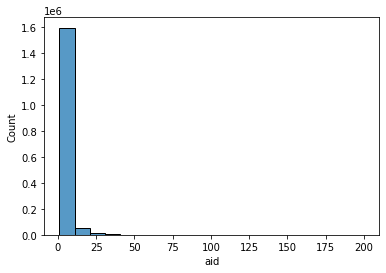

In [ ]:
sns.histplot(
    data=training_skeleton.groupby('session', as_index=False).agg({'aid' : 'count'}),
    x='aid',
    bins=20
)

In [ ]:
if also_buy:
  also_buy_recs = pd.read_parquet(f'{path_to_candidate_features}/also_buy/')
  also_buy_recs.rename(columns={'pairings' : 'also_buy_pairings'}, inplace=True)
  also_buy_recs = also_buy_recs.loc[also_buy_recs['n'] <= n_also_buy]
  training_skeleton = combine_candidate_dfs(training_skeleton, also_buy_recs, candidate_limit, 'also_buy')
  training_skeleton['also_buy_pairings'] = training_skeleton['also_buy_pairings'].astype('float32')
  del also_buy_recs

In [ ]:
if covisitation:
  covisitation_recs = pd.read_parquet(f'{path_to_candidate_features}/covisitation/', engine='fastparquet')
  training_skeleton = combine_candidate_dfs(training_skeleton, covisitation_recs, candidate_limit, 'covisitation')
  del covisitation_recs

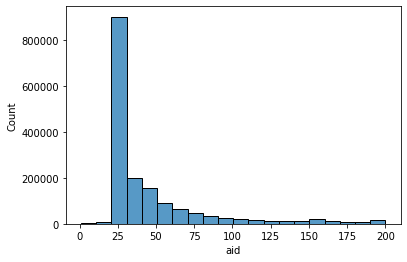

In [ ]:
sns.histplot(
    data=training_skeleton.groupby('session', as_index=False).agg({'aid' : 'count'}),
    x='aid',
    bins=20
)

In [ ]:
if cart_order:
  cart_order_recs = pd.read_parquet(f'{path_to_candidate_features}/cart_order/', engine='fastparquet')
  cart_order_recs.rename(columns={'pairings' : 'cart_order_pairings'}, inplace=True)
  cart_order_recs = cart_order_recs.loc[cart_order_recs['n'] <= n_cart_order]
  training_skeleton = combine_candidate_dfs(training_skeleton, cart_order_recs, candidate_limit, 'cart_order')
  del cart_order_recs

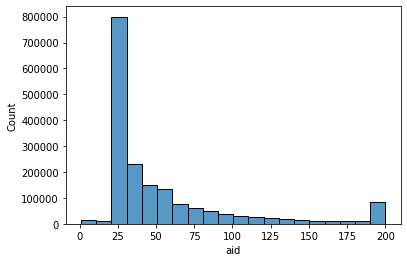

In [ ]:
  sns.histplot(
    data=training_skeleton.groupby('session', as_index=False).agg({'aid' : 'count'}),
    x='aid',
    bins=20)

In [ ]:
if word2vec:
  word2vec_recs = pd.read_parquet(f'{path_to_candidate_features}/word2vec/', engine='fastparquet')
  word2vec_recs = word2vec_recs.loc[word2vec_recs['n'] <= n_word2vec]
  training_skeleton = combine_candidate_dfs(training_skeleton, word2vec_recs, candidate_limit, 'word2vec')
  training_skeleton['w2vec_dist'] = training_skeleton['w2vec_dist'].astype('float32')
  del word2vec_recs

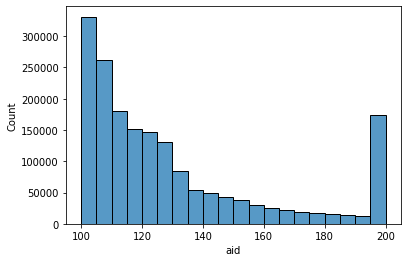

In [ ]:
sns.histplot(
    data=training_skeleton.groupby('session', as_index=False).agg({'aid' : 'count'}),
    x='aid',
    bins=20)

In [ ]:
if als:
  als_recs = pd.read_parquet(f'{path_to_candidate_features}/als/', engine='fastparquet')
  als_recs = als_recs.loc[als_recs['n'] <= n_als]
  als_recs['confidence'] = als_recs['confidence'].astype('float32')
  als_recs = convert_columns(als_recs)
  training_skeleton = combine_candidate_dfs(training_skeleton, als_recs, candidate_limit, 'als')
  training_skeleton['confidence'] = training_skeleton['confidence'].astype('float32')
  del als_recs

1801251


100%|██████████| 10/10 [15:19<00:00, 91.97s/it]


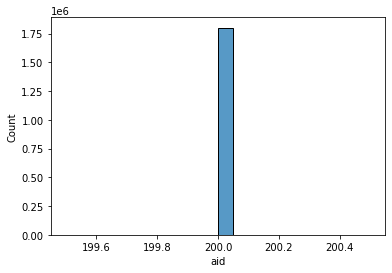

In [ ]:
sns.histplot(
    data=training_skeleton.groupby('session', as_index=False).agg({'aid' : 'count'}),
    x='aid',
    bins=20)

In [ ]:
#with recalculated ALS
calculate_recall(labels, training_skeleton)

clicks recall = 0.6583239060023901
carts recall = 0.5293833979204902
orders recall = 0.7211389613249793
Overall Recall = 0.6573307867713736


0.6573307867713736

In [ ]:
training_skeleton = convert_columns(training_skeleton)
training_skeleton.shape

(360250200, 14)

In [ ]:
make_directory(path_to_training_data)
save_parquet(training_skeleton, f'{path_to_training_data}/training_skeleton', files=100, split_column = 'session')